In [1]:
import pandas as pd
import os

In [2]:
%matplotlib inline
TITANIC_PATH = os.path.join("datasets", "titanic")

def load_titanic_data(filename, titanic_path=TITANIC_PATH):
    csv_path = os.path.join(titanic_path, filename)
    return pd.read_csv(csv_path)

train_kaggle = load_titanic_data("train.csv")
test_kaggle = load_titanic_data("test.csv")

In [22]:
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin, clone
import sys
import re
import sklearn_pandas
import numpy as np
path = '/Users/Asia/Desktop/category_encoders-1.2.6'
sys.path.insert(0, path)
from category_encoders import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

#### Visualise data

In [4]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [5]:
def plot_multiple_scorers(xlabel, results, param, xlim=101):
    """
    plotting results of GridSearch
    """
    plt.figure(figsize=(13, 13))
    plt.title("GridSearchCV evaluating using multiple scorers simultaneously",
              fontsize=16)

    plt.xlabel(xlabel)
    plt.ylabel("Score")
    plt.grid()

    ax = plt.axes()
    ax.set_xlim(0, xlim)
    ax.set_ylim(0.5, 1)

    # Get the regular numpy array from the MaskedArray
    X_axis = np.array(results[param].data, dtype=float)

    for scorer, color in zip(sorted(scoring), ['g', 'k']):
        for sample, style in (('train', '--'), ('test', '-')):
            sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
            sample_score_std = results['std_%s_%s' % (sample, scorer)]
            ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                            sample_score_mean + sample_score_std,
                            alpha=0.1 if sample == 'test' else 0, color=color)
            ax.plot(X_axis, sample_score_mean, style, color=color,
                    alpha=1 if sample == 'test' else 0.7,
                    label="%s (%s)" % (scorer, sample))

        best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
        best_score = results['mean_test_%s' % scorer][best_index]

        # Plot a dotted vertical line at the best score for that scorer marked by x
        ax.plot([X_axis[best_index], ] * 2, [0, best_score],
                linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

        # Annotate the best score for that scorer
        ax.annotate("%0.2f" % best_score,
                    (X_axis[best_index], best_score + 0.005))

    plt.legend(loc="best")
    plt.grid('off')
    plt.show()

#### Preparing data

In [6]:
class CategoricalEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, categories=None):
        self.categories = categories
    
    def get_feature_names(self):
        if self.categories is None:
            return [c for c,i in self.onehotencoder_.ordinal_encoder.mapping[0]['mapping']]
        else:
            return self.categories
        
    def fit(self, X, y=None):
        try:
            self.onehotencoder_ = OneHotEncoder(cols = list(X.columns), return_df=False, handle_unknown='ignore')
        except AttributeError:
            self.onehotencoder_ = OneHotEncoder(return_df=False, handle_unknown='ignore')
        self.onehotencoder_.fit(X)
        
    def transform(self, X):
        res = self.onehotencoder_.transform(X)

        if self.categories is not None:
            idxs = [i for c,i in self.onehotencoder_.ordinal_encoder.mapping[0]['mapping'] if c in set(self.categories)]
            return res[:, idxs]
            
        return res

In [7]:
class TicketStats(BaseEstimator, TransformerMixin):
    def get_feature_names(self):
        return ['Survived','Sex','Count']
    
    def fit(self, X, y):
        s = np.zeros(len(X))
        s[X.Sex=='female'] = 1
        
        tmp = X.assign(Sex=s, Survived=y)
        
        self.ticketstats_ = tmp.groupby('Ticket').sum()[['Survived','Sex']]
        
        self.ticketstats_ = self.ticketstats_.assign(Count = tmp.groupby('Ticket').count().PassengerId)
        
        self.ticketstats_.columns = self.get_feature_names()
        
        return self
        
    def transform(self, X):
        res = X.join(self.ticketstats_, on='Ticket', lsuffix='aa')
        res = res.fillna(0)

        return res[self.get_feature_names()]

In [8]:
class CleanTitles(BaseEstimator, TransformerMixin):
    titlemap = {
            'Capt.': 'Military',
            'Col.': 'Military',
            'Don.': 'Mr.',
            'Dona.': 'Mrs.',
            'Dr.': 'Dr.',
            'Jonkheer.': 'Mr.',
            'Lady.': 'Nobility',
            'Major.': 'Military',
            'Master.': 'Master.',
            'Miss.': 'Miss.',
            'Mlle.': 'Miss.',
            'Mme.': 'Mrs.',
            'Mr.': 'Mr.',
            'Mrs.': 'Mrs.',
            'Ms.': 'Miss.',
            'Rev.': 'Clergy',
            'Sir.': 'Nobility',
            'the Countess.': 'Nobility'
    }

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        @np.vectorize
        def get_title(t):
            return self.titlemap[t.split(', ')[1].split('.')[0]+'.']
        return X.assign(Name=get_title(X.Name)).as_matrix()

In [9]:
class CategoricalImputer(BaseEstimator, TransformerMixin):
    def __init__(self, categories, imputer, drop_categories=True):
        self.categories = categories
        self.imputer = imputer
        self.drop_categories = drop_categories
        
    def fit(self, X, y=None):
        self.imputers_ = {}
        
        for c in self.categories:
            if len(X[X[:,0]==c]) > 0:
                imp = sklearn.base.clone(self.imputer)
                imp.fit(X[X[:,0]==c, 1:])
                if sum(~np.isnan(imp.statistics_))>0:
                    self.imputers_[c] = imp
            
        self.defaultimputer_ = sklearn.base.clone(self.imputer)
        self.defaultimputer_.fit(X[:, 1:])
        
        return self
        
    def transform(self, X):
        X = X.copy()
        
        for c, i in self.imputers_.items():
            if sum(X[:,0]==c) > 0:
                X[X[:,0]==c, 1:] = i.transform(X[X[:,0]==c, 1:])
            
        X[:, 1:] = self.defaultimputer_.transform(X[:, 1:])
        
        if self.drop_categories:
            return X[:, 1:]
        else:
            return X

In [10]:
class CabinFeatures(BaseEstimator, TransformerMixin):
    decks = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T']
    
    def get_feature_names(self):
        return self.decks + ['cabin']
    
    def _extract_decks(self, X):
        return [set(re.sub('\d+| ','',c)) for c in X.Cabin.fillna('')]
    
    def _extract_numbers(self, X):
        def mean_cabin(c):
            l = re.sub('[A-Z] ?','',c).split(' ')
            arr = np.array([int(x) for x in l if x!=''])
            if len(arr):
                return arr.mean()
            else:
                return np.nan
        return [mean_cabin(c) for c in X.Cabin.fillna('')]
    
    def _preprocess(self, X):
        deckonehot = self.deckbinarizer_.transform(self._extract_decks(X))
        cabav = self._extract_numbers(X)

        df = pd.DataFrame(deckonehot, columns = self.deckbinarizer_.classes_).assign(cabav=cabav)
        
        df.loc[df.F==1,list(set(self.deckbinarizer_.classes_) - {'F'})] = 0
        
        deck = self.deckbinarizer_.inverse_transform(df[self.deckbinarizer_.classes_].as_matrix())
        df = df.assign(deck=[d[0] if len(d) else 'NaN' for d in deck])
        
        return df
    
    def fit(self, X, y=None):
        self.deckbinarizer_ = MultiLabelBinarizer(classes = self.decks)
        self.deckbinarizer_.fit(self._extract_decks(X))
       
        df = self._preprocess(X)
        
        self.cabinimputer_ = CategoricalImputer(self.decks, Imputer())
        self.cabinimputer_.fit(df[['deck', 'cabav']].as_matrix())
        
        return self
        
    def transform(self, X):
        df = self._preprocess(X)

        cabav = self.cabinimputer_.transform(df[['deck', 'cabav']].as_matrix())
        
        df = df.assign(cabav=cabav)
                
        return df[list(self.deckbinarizer_.classes_) + ['cabav']].as_matrix()

In [11]:
num_features = sklearn_pandas.gen_features([['SibSp'], ['Parch'], ['Fare']], [Imputer])

cat_features = [
                (['Pclass'], CategoricalEncoder()),
                (['Embarked'], CategoricalEncoder(categories=['C', 'Q', 'S'])),
                (['Sex'], CategoricalEncoder(categories=['female']))
               ]

ticket_features = [(['Ticket', 'Sex', 'PassengerId'], TicketStats(), {'alias': 'TicketStats'})]

cabin_features = [(['Cabin'], CabinFeatures(), {'alias': 'Deck'})]

title_features = [
                  (['Name', 'Age'], [CleanTitles(), CategoricalImputer(set(CleanTitles.titlemap.values()), Imputer())], {'alias': 'Age'}),
                  (['Name'], [CleanTitles(), CategoricalEncoder()], {'alias': 'Title'})
                 ]

data_pipe = sklearn_pandas.DataFrameMapper(num_features + cat_features + cabin_features + title_features + ticket_features, df_out=True, input_df=True)
data_pipe_no_ticket = sklearn_pandas.DataFrameMapper(num_features + cat_features + cabin_features + title_features, df_out=True, input_df=True)

### Data splitting from kaggle train set without a ticket column

In [12]:
train = data_pipe_no_ticket.fit_transform(train_kaggle, train_kaggle.Survived)

In [13]:
train.Title_Clergy.value_counts()

0    885
1      6
Name: Title_Clergy, dtype: int64

#### To make sure that the train set and split test set contain similar data in columns with the prefix "Titles", 
#### I have created the train_test_split_balanced () function

In [14]:
def train_test_split_balanced(data):
    '''takes in data, returns X_train and X_test'''
    
    titles = ['Title_Mr.', 'Title_Mrs.', 'Title_Miss.',
       'Title_Master.', 'Title_Clergy', 'Title_Dr.', 'Title_Military',
       'Title_Nobility']
    train_idx, test_idx = [],[]
    for i in titles:
        r = np.array(data[data[i]==1].index)
        np.random.shuffle(r)
        t = int(np.ceil(len(r)*0.8))
        train_idx.extend(r[:t])
        test_idx.extend(r[t:])
        
    return data.iloc[train_idx], data.iloc[test_idx]

In [15]:
X_train, X_test = train_test_split_balanced(train)

In [16]:
y_test = train_kaggle[['Survived']].iloc[X_test.index]
y_train = train_kaggle[['Survived']].iloc[X_train.index]

y_testt = np.ravel(y_test)
y_test = np.array(y_testt).astype(int)

y_trainn = np.ravel(y_train)
y_train = np.array(y_trainn).astype(int)

In [17]:
X_train.shape

(715, 28)

In [18]:
X_test.shape

(176, 28)

In [19]:
predicted_y = pd.DataFrame() #dataframe with predictions

### SVM ... Support Vector Classification

###### SVM classification on data sets splitted by my function 

In [19]:
from sklearn.svm import SVC
svm_clfr = SVC()
svm_clfr.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [20]:
predicted_y = pd.DataFrame()
predicted_y['Prediction_SVM_default']= svm_clfr.predict(X_test)
print("SVM for default parametres \n\nAccuracy score:")
print(accuracy_score(y_test, predicted_y['Prediction_SVM_default'], normalize=True))

SVM for default parametres 

Accuracy score:
0.7215909090909091


Confusion matrix, without normalization
[[88 22]
 [27 39]]


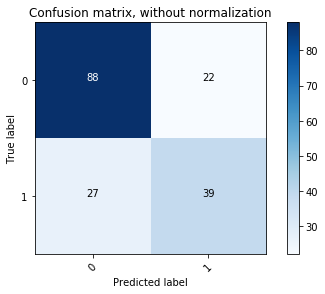

In [21]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, predicted_y['Prediction_SVM_default'])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0, 1], title='Confusion matrix, without normalization')
plt.show()

### Cross-validation for the whole train set from kaggle

#### SVM with default parametres

In [22]:
cvscores_svm = cross_val_score(svm_clfr, train, train_kaggle.Survived, cv=10)
"""
 train is a dataframe with transformed features 
"""
print("Average score: ", cvscores_svm.mean())

Average score:  0.7476109408693679


### Searching the best parametres -- GridSearch

In [25]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

#### Grid search using kernel "Radial Basis Function"

In [41]:
scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}
parameters = {'C':[0.2, 0.5, 1, 3, 5, 10, 30, 50]}
"""
Lower gamma parameter
"""
gs_svm = GridSearchCV(SVC(kernel='rbf', gamma=0.1), parameters,  cv=10, n_jobs=-1, verbose=3, scoring=scoring, refit='AUC')
gs_svm.fit(train, train_kaggle.Survived)
results = gs_svm.cv_results_

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    6.9s finished


c:\users\asia\appdata\local\programs\python\python36\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
c:\users\asia\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_AUC'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
c:\users\asia\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('std_train_AUC

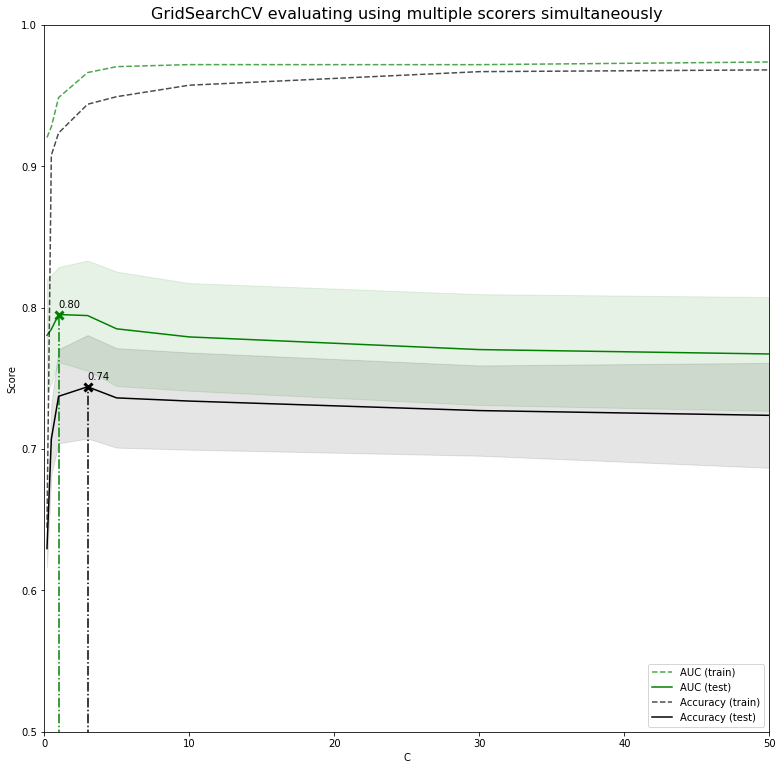

In [42]:
plot_multiple_scorers("C", results, "param_C", xlim = 50)

In [48]:
scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}
parameters = {'C':[0.2, 0.5, 1, 3, 5, 10, 30]}
"""
Higher gamma parameter
"""
gs_svm = GridSearchCV(SVC(kernel='rbf', gamma=10), parameters,  cv=10, n_jobs=-1, verbose=3, scoring=scoring, refit='AUC')
gs_svm.fit(train, train_kaggle.Survived)
results_2 = gs_svm.cv_results_

Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    7.4s finished


c:\users\asia\appdata\local\programs\python\python36\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
c:\users\asia\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_AUC'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
c:\users\asia\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('std_train_AUC

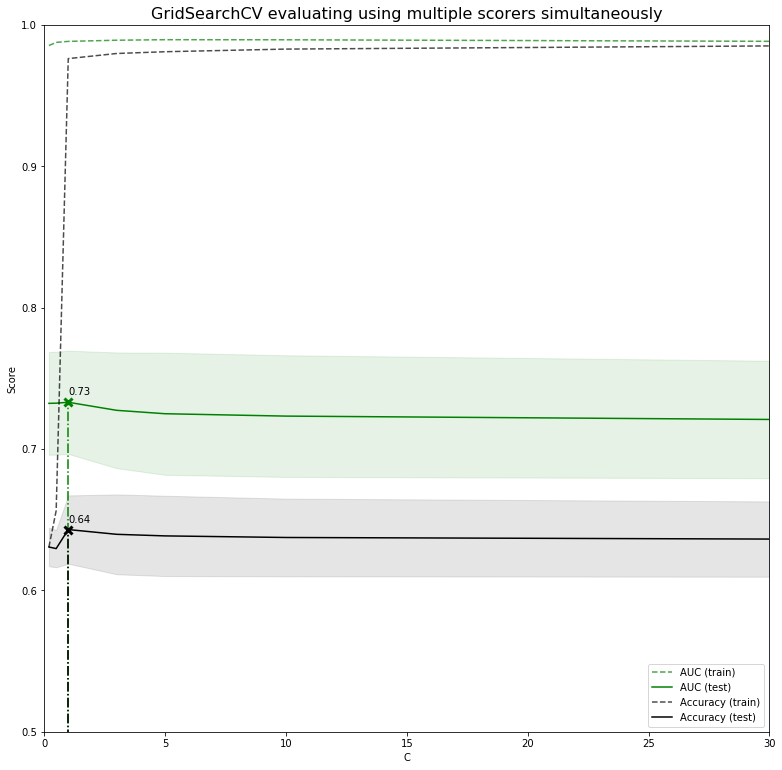

In [49]:
plot_multiple_scorers("C", results_2, "param_C", xlim = 30)

#### Grid search using kernel "Linear"

In [50]:
parameters = {'C':[0.2, 0.5, 1, 3, 5, 10, 30]}
gs_svm_linear = GridSearchCV(SVC(kernel='linear'), parameters,  cv=5, n_jobs=-1, verbose=3, scoring=scoring, refit='AUC')
gs_svm_linear.fit(train, train_kaggle.Survived) 
results_l = gs_svm_linear.cv_results_

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   50.0s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:  2.5min finished


c:\users\asia\appdata\local\programs\python\python36\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
c:\users\asia\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_AUC'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
c:\users\asia\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('std_train_AUC

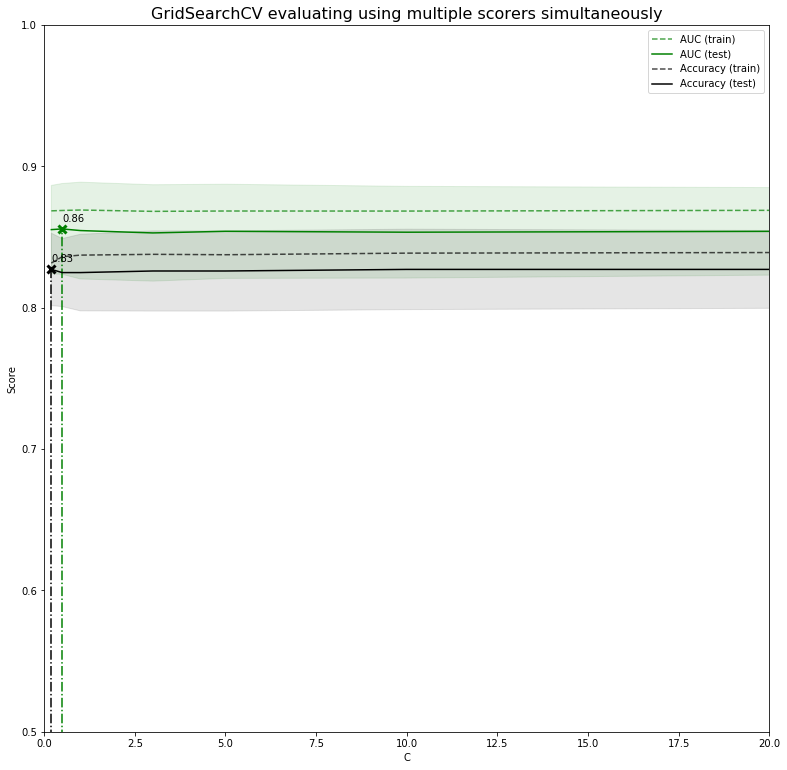

In [53]:
plot_multiple_scorers("C", results_l, "param_C", 20)

### Random Forest

###### Randoom Forest classification on data sets splitted by my function 

In [27]:
from sklearn.ensemble import RandomForestClassifier

forest_clfr = RandomForestClassifier(random_state=42)
forest_clfr.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [28]:
predicted_y['Prediction_RF'] = forest_clfr.predict(X_test) #default parametres

In [29]:
print("Random Forest with default parametres \nAccuracy score:")
print(accuracy_score(y_test, predicted_y['Prediction_RF'], normalize=True))

Random Forest with default parametres 
Accuracy score:
0.7670454545454546


Confusion matrix, without normalization
[[90 12]
 [29 45]]


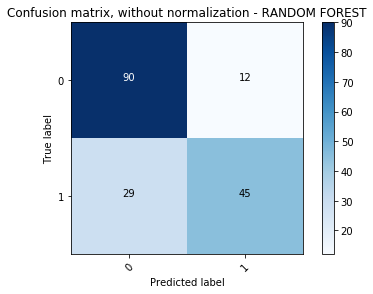

In [30]:
# Compute confusion matrix
cnf_matrix_rf = confusion_matrix(y_test, predicted_y['Prediction_RF'])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_rf, classes=[0, 1],
                      title='Confusion matrix, without normalization - RANDOM FOREST')
plt.show()

#### Cross-validation - default parametres

In [31]:
forest_clfr2 = RandomForestClassifier(random_state=42)
cvscores_RF = cross_val_score(forest_clfr2, train, train_kaggle.Survived, cv=10)
print("Average score: ", cvscores_RF.mean())


Average score:  0.8127309612983771


#### Searching the best parametres -- GridSearch

In [33]:
scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}
param_grid = {"max_depth": range(2, 10, 2),
              "max_features": range(2,10, 2),
              "min_samples_split": [2, 3],
              "min_samples_leaf": [1, 2, 3],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"],
             "n_estimators": range(2, 20, 5)}

rf_clf_GS = GridSearchCV(RandomForestClassifier(random_state=42), param_grid=param_grid, cv=3,scoring=scoring, refit='AUC', n_jobs=-1, verbose=3)
rf_clf_GS.fit(train, train_kaggle.Survived)
results_RF = rf_clf_GS.cv_results_

Fitting 3 folds for each of 1536 candidates, totalling 4608 fits


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 355 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 995 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done 1891 tasks      | elapsed:   38.4s
[Parallel(n_jobs=-1)]: Done 3043 tasks      | elapsed:   58.1s
[Parallel(n_jobs=-1)]: Done 4451 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 4608 out of 4608 | elapsed:  1.4min finished


In [34]:
rf_clf_GS.best_params_

{'bootstrap': False,
 'criterion': 'entropy',
 'max_depth': 8,
 'max_features': 4,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 7}

In [35]:
rf_clf_GS.best_score_

0.8749001374109227

In [38]:
param_grid2 = {"n_estimators": range(2, 50), "max_depth": [8], "max_features":[4]}

rf_clf_GSt = GridSearchCV(RandomForestClassifier(random_state=42), param_grid=param_grid2, cv=3,scoring=scoring, refit='AUC', n_jobs=-1, verbose=3)
rf_clf_GSt.fit(train, train_kaggle.Survived)
results_test = rf_clf_GSt.cv_results_

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:   12.0s finished


c:\users\asia\appdata\local\programs\python\python36\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
c:\users\asia\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_AUC'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
c:\users\asia\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('std_train_AUC

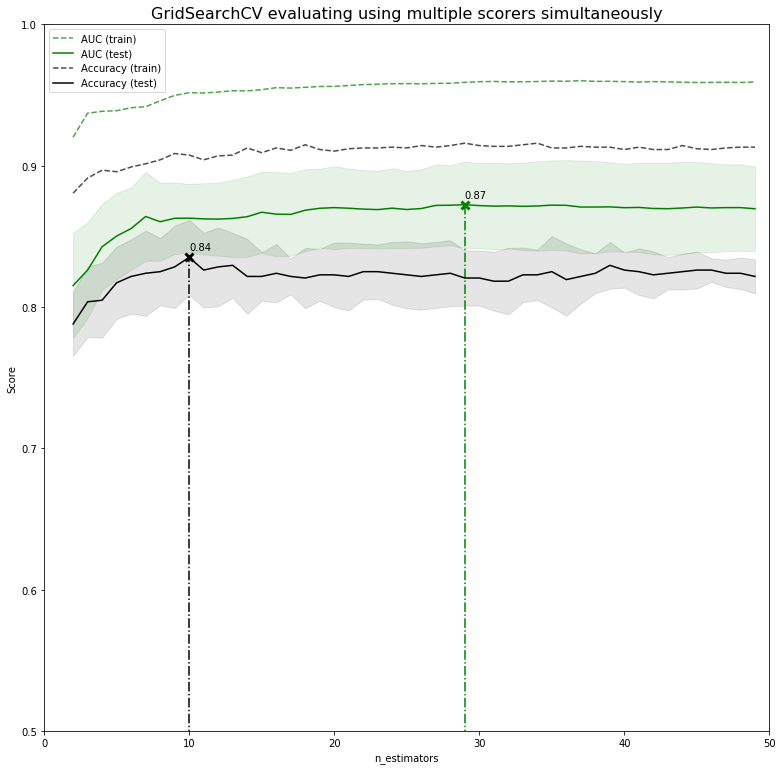

In [41]:
plot_multiple_scorers("n_estimators", results_test, "param_n_estimators", xlim=50)

### Logistic Regression

#### Predictions on my splitted data. Default parametres set. 

In [20]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

regr = linear_model.LogisticRegression()
regr.fit(X_train, y_train)

predicted_y['Prediction_LR'] = regr.predict(X_test)
print("Accuracy score: ", accuracy_score(y_test, predicted_y['Prediction_LR']))

Accuracy score:  0.8125


#### Cross-validation . Default parametres.

In [23]:
cvscores_lr = cross_val_score(linear_model.LogisticRegression(), train, train_kaggle.Survived, cv=10)
print("Average score: ", cvscores_lr.mean())

Average score:  0.8350527749404154


#### Searching the best parametres -- GridSearch

In [64]:
# Create regularization penalty space
penalty = ['l1', 'l2']
# Create regularization hyperparameter space
hyperparameters = {"C": np.linspace(0.1, 10, 30),
                  "penalty": ('l1', 'l2')}
scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}
#dict(C=C, penalty=penalty)

In [65]:
regr_clf_GS = GridSearchCV(linear_model.LogisticRegression(), param_grid=hyperparameters, scoring=scoring, refit="AUC", cv=10, verbose=0, return_train_score=True)
regr_clf_GS.fit(train, train_kaggle.Survived)
results_rl = regr_clf_GS.cv_results_

c:\users\asia\appdata\local\programs\python\python36\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
c:\users\asia\appdata\local\programs\python\python36\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


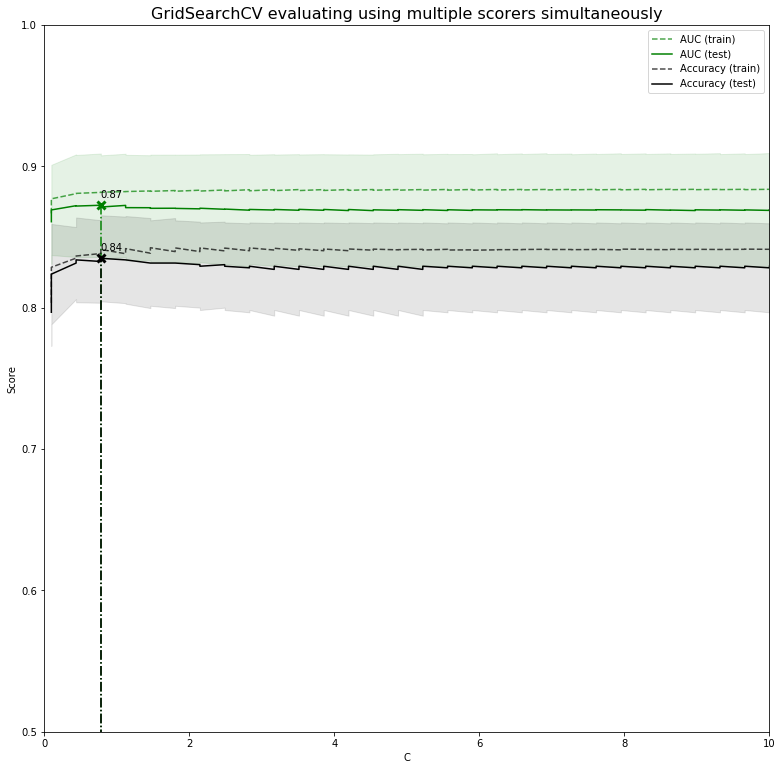

In [66]:
plot_multiple_scorers("C", results_rl, "param_C", xlim = 10)

## XGBoost 

In [68]:
import xgboost as xgb

In [86]:
trainn = train[:]
trainn.head()

,SibSp,Parch,Fare,Pclass_3,Pclass_1,Pclass_2,Embarked_C,Embarked_Q,Embarked_S,Sex,...,Deck_cabin,Age,Title_Mr.,Title_Mrs.,Title_Miss.,Title_Master.,Title_Clergy,Title_Dr.,Title_Military,Title_Nobility
0,1,0,7.25,1,0,0,1,0,0,0,...,50.6675,22,1,0,0,0,0,0,0,0
1,1,0,71.2833,0,1,0,0,1,0,1,...,85,38,0,1,0,0,0,0,0,0
2,0,0,7.925,1,0,0,1,0,0,1,...,50.6675,26,0,0,1,0,0,0,0,0
3,1,0,53.1,0,1,0,1,0,0,1,...,123,35,0,1,0,0,0,0,0,0
4,0,0,8.05,1,0,0,1,0,0,0,...,50.6675,35,1,0,0,0,0,0,0,0


In [90]:
for feature in trainn.columns: # Loop through all columns in the dataframe
    if trainn[feature].dtype == 'object' and feature not in ('Fare', 'Deck_cabin'): 
        trainn[feature] = pd.Categorical(trainn[feature]).codes # Replace strings with an integer
    else:
        trainn[feature] = train[feature].astype(float)        

In [100]:
cv_params = {'max_depth': [1,3,5,7], 'min_child_weight': [1,3,5,7,10]}
ind_params = {'learning_rate': 0.1, 'n_estimators': 1000, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic'}

optimized_GBM = GridSearchCV(xgb.XGBClassifier(**ind_params), 
                             cv_params, 
                             scoring = 'accuracy',
                             cv = 5,
                             n_jobs = -1) 

In [101]:
optimized_GBM.fit(trainn, train_kaggle.Survived)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=True,
       subsample=0.8),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': [1, 3, 5, 7], 'min_child_weight': [1, 3, 5, 7, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [103]:
optimized_GBM.best_score_

0.8395061728395061

In [104]:
optimized_GBM.best_params_

{'max_depth': 3, 'min_child_weight': 5}

In [108]:
xgdmat = xgb.DMatrix(trainn, train_kaggle.Survived)

final_params = {'eta': 0.1, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic', 'max_depth':3, 'min_child_weight':5} 

final_gb = xgb.train(final_params, xgdmat, num_boost_round = 432)

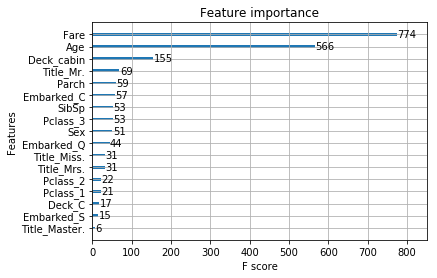

In [109]:
xgb.plot_importance(final_gb)
